In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import numpy as np

In [26]:
returns = pd.read_csv('../data2/lsret.csv', parse_dates=['date'], index_col='date')
returns

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,
1926-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-13.686396,NaN,NaN,NaN,NaN,NaN,NaN
1926-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-5.135249,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.832504,NaN,NaN,NaN,NaN,NaN,NaN
1926-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.440908,NaN,NaN,NaN,NaN,NaN,NaN
1926-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.483252,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-2.811101,0.352037,-3.505424,2.124068,-3.255641,NaN,NaN,-3.993847,-8.544082,-0.468824,...,-0.572368,10.653366,10.519512,1.314790,NaN,9.055350,-2.542115,7.659403,7.117891,6.346115
2023-09-29,0.922941,-0.114425,-4.978345,-1.303447,-1.357611,NaN,NaN,-3.505014,-3.765754,-0.080998,...,0.496558,7.055164,13.252843,-2.008975,NaN,3.892683,0.505730,5.377765,2.727548,5.213919
2023-10-31,-0.134826,0.771166,-2.895934,-1.476006,-8.193653,NaN,NaN,-4.306018,-5.404844,-1.106162,...,5.018342,8.422002,9.911237,-5.063718,NaN,7.088323,-0.400864,2.923720,2.078957,3.412397


Mental notes:

lsret - factor investing returns per month.

"In October 2023, a strategy that
bought stocks with low accruals and
shorted stocks with high accruals
earned −1.48% that month."

Every cell is just the performance of a “factor strategy” during that month.

return logic:
Top group by certain charactersitic = “long”
Bottom group = “short”

In [27]:
# Import q1 data

import pickle

with open("ls_returns_df.pkl", "rb") as f:
    ls_returns_df = pickle.load(f)

ls_returns_df.index.name = "date"
ls_returns_df


,AM,AOP,AbnormalAccruals,Accruals,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,...,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,skew1,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,
1980-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.143644,NaN
1980-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023398,NaN
1980-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010369,-0.025081
1981-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016791,-0.091380
1981-04-01,NaN,NaN,NaN,NaN,NaN,NaN,-0.009187,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.083535,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,-0.102753,0.000724,0.030043,0.067191,-0.101084,NaN,NaN,-0.086533,0.087090,-0.025627,...,NaN,NaN,0.095433,0.049514,0.020039,-0.003754,-0.042603,0.008892,0.027686,0.031552
2022-08-01,-0.008612,-0.039070,-0.004765,-0.003773,0.022900,0.157895,0.053870,-0.023717,0.168663,0.009299,...,0.069962,0.061561,0.014960,-0.021701,-0.045620,0.017262,0.044119,-0.034932,-0.049290,-0.052024
2022-09-01,-0.015784,-0.018341,-0.011092,0.015229,-0.067626,NaN,NaN,-0.009982,0.051101,0.049543,...,NaN,0.010153,-0.019127,0.059149,0.018990,0.025506,-0.032747,0.005641,0.019371,0.009875


In [28]:
with open("ls_returns_small_df.pkl", "rb") as f:
    ls_returns_small_df = pickle.load(f)

# Convert integer index to datetime and set name
ls_returns_small_df.index = pd.to_datetime(ls_returns_small_df.index, format="%Y%m")
ls_returns_small_df.index.name = "date"
ls_returns_small_df


,Beta,BetaFP,BetaTailRisk,BidAskSpread,Coskewness,DivInit,DivOmit,DolVol,ExchSwitch,FirmAge,...,ShareIss5Y,ShareVol,Spinoff,VolMkt,VolSD,VolumeTrend,std_turn,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,
1926-03-01,NaN,NaN,NaN,-0.200513,NaN,NaN,NaN,0.021639,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.040121,NaN
1926-04-01,NaN,NaN,NaN,-0.365921,NaN,NaN,NaN,-0.274993,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-06-01,NaN,NaN,NaN,-0.175821,NaN,0.023595,NaN,-0.107338,NaN,NaN,...,NaN,-0.045364,NaN,NaN,NaN,NaN,NaN,NaN,-0.021109,NaN
1926-07-01,NaN,NaN,NaN,-0.094417,NaN,NaN,NaN,-0.113007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007298,-0.027238
1926-08-01,NaN,NaN,NaN,0.076008,NaN,NaN,NaN,0.246736,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.251483,0.281650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,NaN,NaN,NaN,-0.083472,-0.036052,NaN,NaN,0.036163,NaN,NaN,...,NaN,NaN,NaN,-0.046534,NaN,NaN,NaN,-0.011430,0.023681,0.004350
2022-08-01,NaN,NaN,NaN,-0.015659,0.041127,NaN,NaN,0.006597,NaN,NaN,...,NaN,NaN,NaN,0.029544,NaN,NaN,NaN,0.069041,-0.009216,0.069281
2022-09-01,NaN,NaN,NaN,0.063794,-0.074914,NaN,NaN,-0.111416,NaN,NaN,...,NaN,NaN,NaN,-0.078986,NaN,NaN,NaN,-0.012275,-0.004322,-0.016190


In [29]:
# ============================================================================
# Data Cleaning: Prepare all 3 matrices for PCA
# PCA cannot handle NaN, so we need to:
#   1) Drop columns that are mostly NaN
#   2) Drop remaining rows with any NaN
# ============================================================================

def clean_for_pca(df, name, max_missing_frac=0.3):
    """Drop columns with too many NaNs, then drop rows with any remaining NaN."""
    print(f"\n{'='*60}")
    print(f"Cleaning: {name}")
    print(f"{'='*60}")
    print(f"Original shape: {df.shape}")
    
    # Step 1: Column-level missingness
    col_missing = df.isna().mean()
    cols_keep = col_missing[col_missing <= max_missing_frac].index.tolist()
    cols_drop = col_missing[col_missing > max_missing_frac].index.tolist()
    print(f"Dropping {len(cols_drop)} columns with >{max_missing_frac*100:.0f}% missing")
    df_clean = df[cols_keep]
    
    # Step 2: Drop rows with any remaining NaN
    n_before = len(df_clean)
    df_clean = df_clean.dropna()
    print(f"Dropped {n_before - len(df_clean)} rows with remaining NaN")
    print(f"Final shape: {df_clean.shape}")
    print(f"Date range: {df_clean.index[0]} to {df_clean.index[-1]}")
    
    return df_clean

# Clean each matrix
returns_clean = clean_for_pca(returns, "lsret.csv", max_missing_frac=0.3)
ls_large_clean = clean_for_pca(ls_returns_df, "Large-cap (Q1a)", max_missing_frac=0.3)
ls_small_clean = clean_for_pca(ls_returns_small_df, "Small-cap (Q1d)", max_missing_frac=0.3)



Cleaning: lsret.csv
Original shape: (1176, 212)
Dropping 104 columns with >30% missing
Dropped 358 rows with remaining NaN
Final shape: (818, 108)
Date range: 1954-07-30 00:00:00 to 2023-08-31 00:00:00

Cleaning: Large-cap (Q1a)
Original shape: (356, 187)
Dropping 53 columns with >30% missing
Dropped 168 rows with remaining NaN
Final shape: (188, 134)
Date range: 1993-06-01 00:00:00 to 2022-11-01 00:00:00

Cleaning: Small-cap (Q1d)
Original shape: (255, 47)
Dropping 32 columns with >30% missing
Dropped 107 rows with remaining NaN
Final shape: (148, 15)
Date range: 1927-06-01 00:00:00 to 2022-10-01 00:00:00


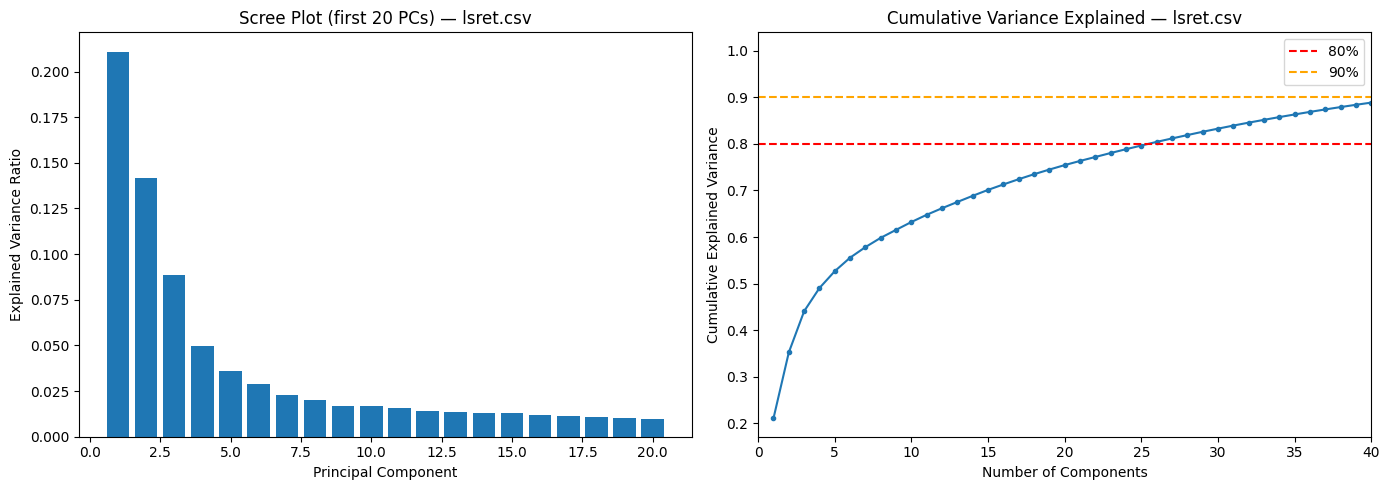

Components for 80% variance: 26
Components for 90% variance: 43

Annualized Sharpe ratios of first 10 PC factors:
  PC1: Sharpe = 0.000  (explains 21.1% of variance)
  PC2: Sharpe = -0.000  (explains 14.1% of variance)
  PC3: Sharpe = -0.000  (explains 8.8% of variance)
  PC4: Sharpe = 0.000  (explains 5.0% of variance)
  PC5: Sharpe = -0.000  (explains 3.6% of variance)
  PC6: Sharpe = -0.000  (explains 2.9% of variance)
  PC7: Sharpe = -0.000  (explains 2.3% of variance)
  PC8: Sharpe = -0.000  (explains 2.0% of variance)
  PC9: Sharpe = -0.000  (explains 1.7% of variance)
  PC10: Sharpe = -0.000  (explains 1.7% of variance)


In [30]:
# ============================================================================
# Example: PCA on lsret.csv
# ============================================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize (zero mean, unit variance) — important so high-vol
# portfolios don't dominate PCA
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_clean)

# Step 2: Fit PCA (keep all components to examine explained variance)
pca_lsret = PCA()
pca_lsret.fit(returns_scaled)

# Step 3: Explained variance
cumulative_var = np.cumsum(pca_lsret.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 21), pca_lsret.explained_variance_ratio_[:20])
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("Scree Plot (first 20 PCs) — lsret.csv")

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, marker='.')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80%')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90%')
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Variance Explained — lsret.csv")
axes[1].legend()
axes[1].set_xlim(0, 40)

plt.tight_layout()
plt.show()

# How many factors to reach 80% / 90%?
n_80 = np.searchsorted(cumulative_var, 0.80) + 1
n_90 = np.searchsorted(cumulative_var, 0.90) + 1
print(f"Components for 80% variance: {n_80}")
print(f"Components for 90% variance: {n_90}")

# Step 4: Factor returns (PC scores) and their Sharpe ratios
factor_returns = pd.DataFrame(
    pca_lsret.transform(returns_scaled),
    index=returns_clean.index,
    columns=[f"PC{i+1}" for i in range(returns_scaled.shape[1])]
)

# Sharpe ratios of first few factors
print("\nAnnualized Sharpe ratios of first 10 PC factors:")
for i in range(min(10, factor_returns.shape[1])):
    col = f"PC{i+1}"
    mu = factor_returns[col].mean()
    sd = factor_returns[col].std(ddof=1)
    sr = (mu / sd) * np.sqrt(12) if sd > 0 else np.nan
    var_pct = pca_lsret.explained_variance_ratio_[i] * 100
    print(f"  {col}: Sharpe = {sr:.3f}  (explains {var_pct:.1f}% of variance)")


In [31]:
# ============================================================================
# Interpret PCs: inspect loadings to see what each factor "is"
# ============================================================================

# Each row of pca.components_ is a PC; each column is an original portfolio
loadings = pd.DataFrame(
    pca_lsret.components_,
    columns=returns_clean.columns,
    index=[f"PC{i+1}" for i in range(len(pca_lsret.components_))]
)

# Show top positive and negative loadings for first 3 PCs
for pc in ["PC1", "PC2", "PC3"]:
    sorted_loadings = loadings.loc[pc].sort_values()
    var_pct = pca_lsret.explained_variance_ratio_[int(pc[2:])-1] * 100
    print(f"\n{'='*60}")
    print(f"{pc} ({var_pct:.1f}% of variance)")
    print(f"{'='*60}")
    print(f"\nMost NEGATIVE loadings (short side):")
    print(sorted_loadings.head(5).to_string())
    print(f"\nMost POSITIVE loadings (long side):")
    print(sorted_loadings.tail(5).to_string())



PC1 (21.1% of variance)

Most NEGATIVE loadings (short side):
IdioVolAHT    -0.182995
IdioVol3F     -0.178970
RealizedVol   -0.177199
ShareIss5Y    -0.176297
MaxRet        -0.170276

Most POSITIVE loadings (long side):
RD              0.156218
Price           0.158200
BidAskSpread    0.174336
BetaFP          0.176990
Beta            0.190624

PC2 (14.1% of variance)

Most NEGATIVE loadings (short side):
VarCF                 -0.115302
EarningsConsistency   -0.111606
GrSaleToGrOverhead    -0.084678
CompEquIss            -0.083107
Mom12m                -0.075897

Most POSITIVE loadings (long side):
BM              0.187678
DelCOA          0.188308
MomOffSeason    0.198422
InvestPPEInv    0.201510
DolVol          0.202036

PC3 (8.8% of variance)

Most NEGATIVE loadings (short side):
CashProd   -0.210269
SP         -0.172529
Leverage   -0.155705
AM         -0.152160
EP         -0.133254

Most POSITIVE loadings (long side):
IndMom              0.192888
Mom12mOffSeason     0.199725
Residual